## Script for generating 1D and 2D meshes 
#### The same workflow will work for generating 3D meshes
#### We can read a 2D vtk file for surface elevation as well (not discussed here, but that would be a pretty simple change)
#### Example: Non-uniform soil stratigraphy 

In [1]:
import sys, os, math, scipy.signal
sys.path.insert(0, os.path.join(os.environ['ATS_SRC_DIR'],'tools','meshing_ats', 'meshing_ats'))
import meshing_ats
print(meshing_ats.__file__)
import numpy as np
from matplotlib import pyplot as plt

/Users/ajc/Core/codes/simulator/repos/amanzi/src/physics/ats/tools/meshing_ats/meshing_ats/meshing_ats.py


## Generate x and z coordinate of the 2D surface
### In this example, we have a uniform slope uphill and parabolic-type topography downhill (like a valley bottom)

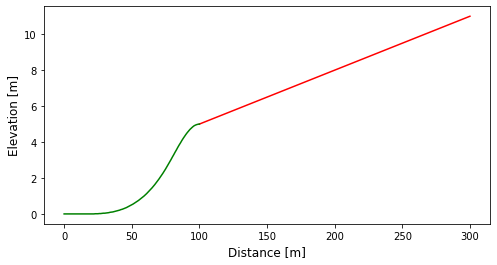

In [2]:
#%matplotlib qt
plt.figure(figsize=(8,4))
slope_pc = 3 #  <-------------------- specify slope for the transect (in percentage)
slope = [slope_pc/100.]

for slope in slope:
    X_dn = np.arange(0,101,1)
    X_up = np.arange(100,301,1)
    z0, z1 = 0, 5 
    z2 = 900* slope + z1
    z_pt = [z0, z1,z2]
    Z_up = z_pt[1] + slope * (X_up - X_up[0])

    plt.plot(X_up,Z_up,'r')

    Z_dn_pt = [z0,z0,2.5,z1]
    X_dn_pt = [X_dn[0], X_dn[20], X_dn[75], X_dn[-1]]
    cs1 = scipy.interpolate.CubicSpline(X_dn_pt,Z_dn_pt, bc_type='clamped')
    Z_dn = np.round(cs1(X_dn),2)
    plt.plot(X_dn,Z_dn,'g')
    plt.xlabel('Distance [m]',fontsize=12,fontweight='normal')
    plt.ylabel('Elevation [m]',fontsize=12,fontweight='normal')

In [3]:
## Merging uphill and downhill coordinates to get a single vector
Z = np.round((np.concatenate((Z_dn, Z_up[1:]))),4)
X = np.round((np.concatenate((X_dn, X_up[1:]))),4)


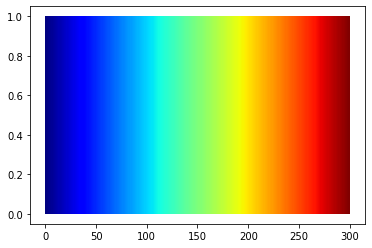

In [4]:
# Generate 2D mesh object
m2 = meshing_ats.Mesh2D.from_Transect(X,Z)
m2.plot()

In [56]:
# Define soil stratigraphy depths
peat_thickness = np.zeros(m2.num_cells())
count = 0
for i in range(m2.num_cells()):
    if count < 10:
        peat_thickness[i] = 0.2
        count = count + 1
    else:
        peat_thickness[i] = 0.06
        count = count + 1
        if (count == 20):
            count = 0

In [57]:
# This can be done in many ways (depending on your personal style), here I use separate for loops to 
# generate/characterize soil layers

layer_types = [] 
layer_data = []    # Depth container
layer_ncells = []  # Number of cells
layer_mat_ids = [] # Layer id
bottom_z = -45.0   # depth at which the bottom boundary is specified when the bottom is flat
z=0
Z = []


# Moss [2 cm], Z = 0.02 m
for i in range(1):
    layer_types.append('constant')
    layer_data.append(0.02)       
    layer_ncells.append(1) 
    layer_mat_ids.append(1001*np.ones((m2.num_cells(),),'i')) 
    z = z + 0.02
    Z.append(z)
print ('Moss ', z)

# Peat [18 cm], Z = 0.2 m
c_start, c_end = 1, 10
for i in range(c_start,c_end,1):
    layer_types.append('constant')
    layer_data.append(0.02)
    layer_ncells.append(1)
    layer_mat_ids.append(-1002*np.ones((m2.num_cells(),),'i')) # <--- this negative id will be replaced later
    z = z + 0.02
    Z.append(z)
print ('Peat ', z)

# Upper mineral [14 cm], Z = 0.34 m
for i in range(7): 
    layer_types.append('constant')
    layer_data.append(0.02)
    layer_ncells.append(1)
    layer_mat_ids.append(1003*np.ones((m2.num_cells(),),'i'))
    z = z + 0.02
    Z.append(z)
print ('Upper mineral 1', z)

# Upper mineral [16 cm], Z = 0.5 m
for i in range(8): 
    layer_types.append('constant')
    layer_data.append(0.02)
    layer_ncells.append(1)
    layer_mat_ids.append(1004*np.ones((m2.num_cells(),),'i'))
    z = z + 0.02
    Z.append(z)
print ('Upper mineral 2', z)

dz = .02
for i in range(35):
    dz *= 1.075
    layer_types.append("constant")
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(1005*np.ones((m2.num_cells(),),'i'))
    z = z + dz
    Z.append(z)
print ('Ice rich', z)

for i in range(25):
    dz *= 1.12
    layer_types.append("constant")
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(1005*np.ones((m2.num_cells(),),'i'))
    z = z + dz
    Z.append(z)
print (z, len(Z))


layer_types.append('snapped')
layer_data.append(bottom_z)
layer_ncells.append(1)
layer_mat_ids.append(1005*np.ones((m2.num_cells(),),'i'))


#---------------------------------------------------------------
# Variable first layer: top = 1001
mat_ids=np.zeros((m2.num_cells(), c_end -c_start), 'i')
print (mat_ids.shape)
for i in range(m2.num_cells()):
    for j in range(c_start,c_end,1):
        #print (j, j-c_start, Z[j])
        if (Z[j] <= peat_thickness[i]):
            mat_ids[i,j-c_start]=1002     
        else:
            mat_ids[i,j-c_start]=1003

for j in range(c_start,c_end,1):
    #print (j)
    layer_mat_ids[j] = mat_ids[:,j-c_start]

m3 = meshing_ats.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, layer_ncells, layer_mat_ids)



Moss  0.02
Peat  0.19999999999999998
Upper mineral 1 0.34
Upper mineral 2 0.5000000000000001
Ice rich 3.816409519999923
41.3555869470643 85
(300, 9)


In [58]:
outfile = "/Users/ajc/Core/PreProcessing/data/meshes/hillslope/hs_rain_heat"
file=  "hs_testingB.exo"
m3.write_exodus(file)

Opening exodus file: hs_testingB.exo
Closing exodus file: hs_testingB.exo
